### TYK2 IL-23 RNA-seq

1. [Dataset Properties](#part1)
2. [Statistical Modeling](#part2)
3. [Global Profiling](#part3)
4. [Gene Visualizations](#part3)

In [27]:
library(ggpubr)
library(DESeq2)
library(ggcorrplot)
library(furrr)
library(patchwork)
library(ComplexHeatmap)
library(tidyverse)

#### Dataset Properties <a name="part1"></a>

In [3]:
alignments <- read_tsv("../pipeline/diffexp/multiqc_data/multiqc_star.txt") %>%
    mutate(id = as.numeric(gsub("_.*", "", Sample)))

count_summary <- read_tsv("../pipeline/diffexp/multiqc_data/multiqc_featureCounts.txt")  %>%
    mutate(id = as.numeric(gsub("_.*", "", Sample)))

Rows: 80 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Sample
dbl (26): insertion_length, unmapped_other, multimapped_toomany_percent, unm...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 80 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Sample
dbl (16): Unassigned_Chimera, Unassigned_Duplicate, Unassigned_NoFeatures, U...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
options(repr.plot.width = 8, repr.plot.height = 18)
alignments %>%
    ggplot() +
        geom_bar(aes(x = total_reads, y = reorder(Sample, -id)), stat = "identity") +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        xlab("Total Read Depth") + ylab("") +
        ggtitle("Total Read Depth")

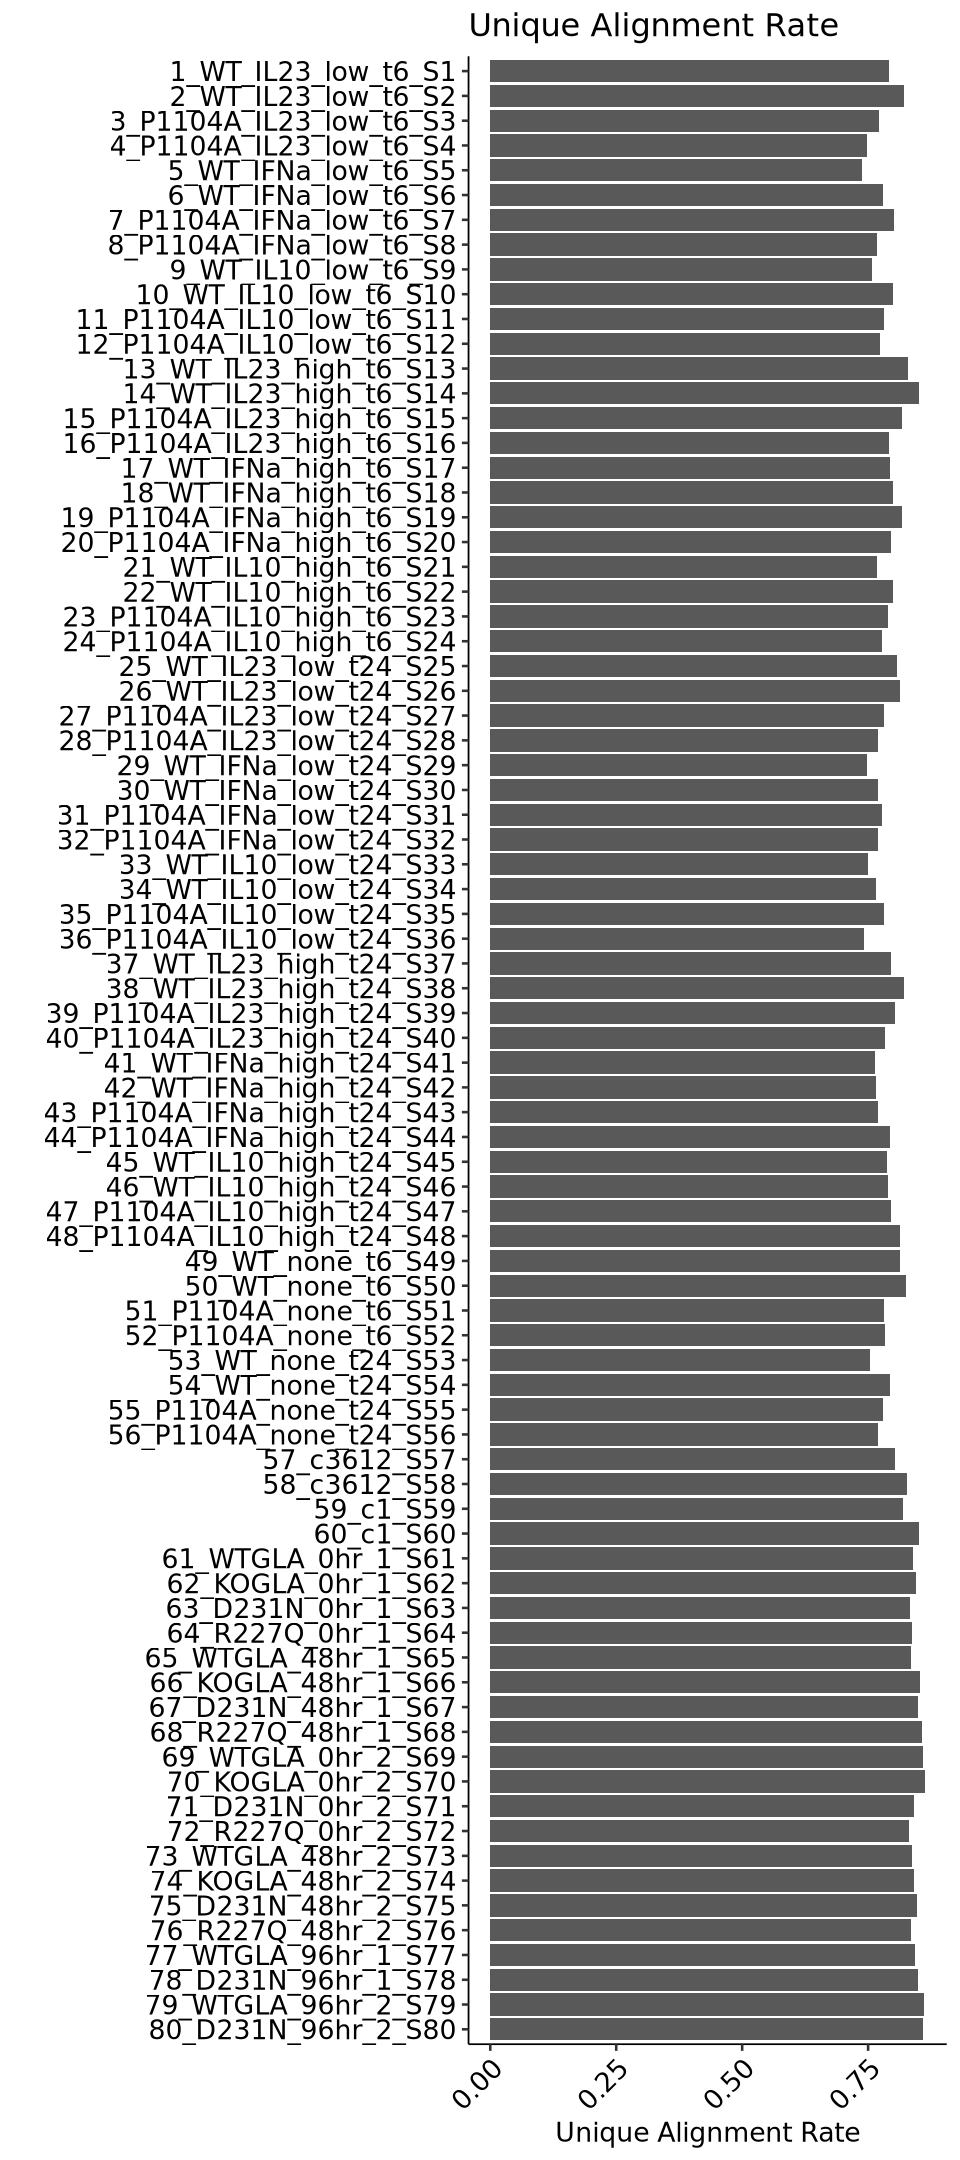

In [5]:
alignments %>%
    ggplot() +
        geom_bar(aes(x = uniquely_mapped_percent/100, y = reorder(Sample, -1*as.numeric(id))), stat = "identity") +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        xlab("Unique Alignment Rate") + ylab("") +
        ggtitle("Unique Alignment Rate")

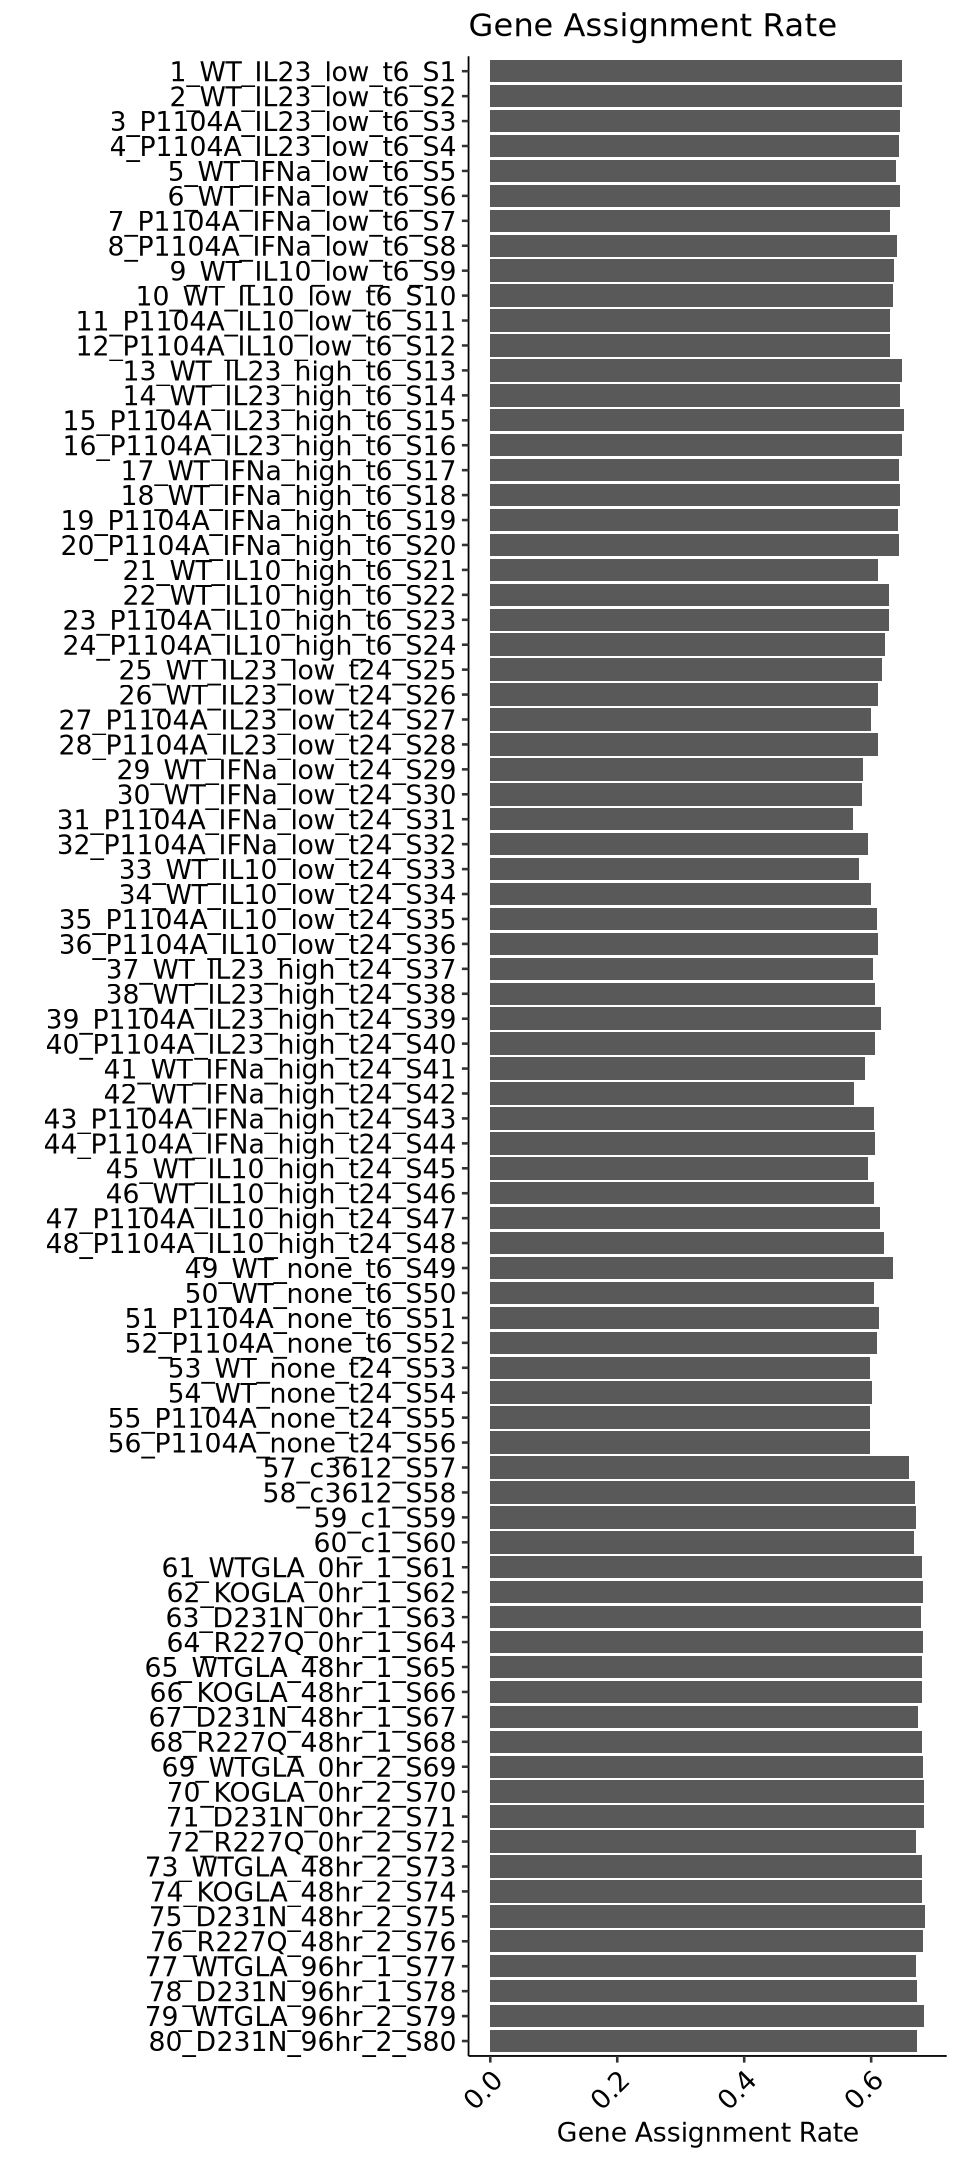

In [6]:
count_summary %>%
    ggplot() +
        geom_bar(aes(x = percent_assigned/100, y = reorder(Sample, -1*as.numeric(id))), stat = "identity") +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        xlab("Gene Assignment Rate") + ylab("") +
        ggtitle("Gene Assignment Rate")

#### Statistical Modeling <a name="part2"></a>

In [8]:
paths <- str_c("../pipeline/diffexp/",
                    alignments$Sample,
                    ".counts.tsv")
names(paths) <- paths
df <- map_dfr(paths,
              ~read_tsv(.x,
                        col_names = NULL,
                        skip = 2,
                        col_select = c(1,7)),
              .id = "sample") %>%
    rename("gene" = "X1",
           "count" = "X7") %>%
    mutate(sample = gsub("../pipeline/diffexp/|.counts.tsv", "", sample))

samp_prop <- read_tsv("../data/diffexp/sample-properties-il23.tsv") %>%
    arrange(sample_id) %>%
    mutate(rep = rep(c(1,2), 40),
           covariate = str_c(group, "_", cytokine, "_", dosage, "_", time))
rownames(samp_prop) <- samp_prop$sample_id

df_id <- df %>%
    mutate(id = as.numeric(gsub("_.*", "", sample))) %>%
    select(-sample) %>%
    arrange(id)

Rows: 60607 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1
dbl (1): X7

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 60607 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1
dbl (1): X7

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 60607 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1
dbl (1): X7

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 60607 Columns: 2
── Column specification ────────────────────────────────────────────────────────

In [12]:
de_data <- df_id %>%
    filter(id %in% 1:56) %>%
    pivot_wider(names_from = id, values_from = count)

de_prop <- samp_prop %>% filter(sample_id %in% 1:56)

deobj_counts <- DESeqDataSetFromMatrix(countData = de_data %>% select(-gene),
    colData = de_prop,
    design = ~covariate)

deresult <- DESeq(deobj_counts)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [32]:
cov_group <- de_prop %>%
    filter(!grepl("none", covariate)) %>%
    distinct(covariate) %>%
    pull(covariate)

none_group <- gsub("IFNa|IL10|IL23|low|high", "none", cov_group)

In [35]:
plan(multicore, workers = 30)
norm_result <- future_map2(.x = cov_group,
                    .y = none_group,
                    ~results(deresult,
                             contrast = c("covariate", .x, .y)))

Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated

In [36]:
sumstats <- map2_dfr(norm_result,
                     cov_group,
                     ~bind_cols("gene" = de_data$gene,
                                            as_tibble(.x),
                                            "condition" = .y))

In [40]:
write_tsv("~/bms-dms/sumstats/RNASEQ/diffexp/

gene        baseMean   log2FoldChange lfcSE     stat      pvalue    padj
1 DDX11L1     0.00000000       NA              NA        NA        NA NA  
2 WASH7P      1.00414157 2.399110        2.364721 1.0145424 0.3103240 NA  
3 MIR6859-1   0.01620713 1.525689       10.986033 0.1388753 0.8895487 NA  
4 MIR1302-2HG 0.00000000       NA              NA        NA        NA NA  
5 MIR1302-2   0.00000000       NA              NA        NA        NA NA  
6 FAM138A     0.00000000       NA              NA        NA        NA NA  
  condition     
1 WT_IL23_low_t6
2 WT_IL23_low_t6
3 WT_IL23_low_t6
4 WT_IL23_low_t6
5 WT_IL23_low_t6
6 WT_IL23_low_t6

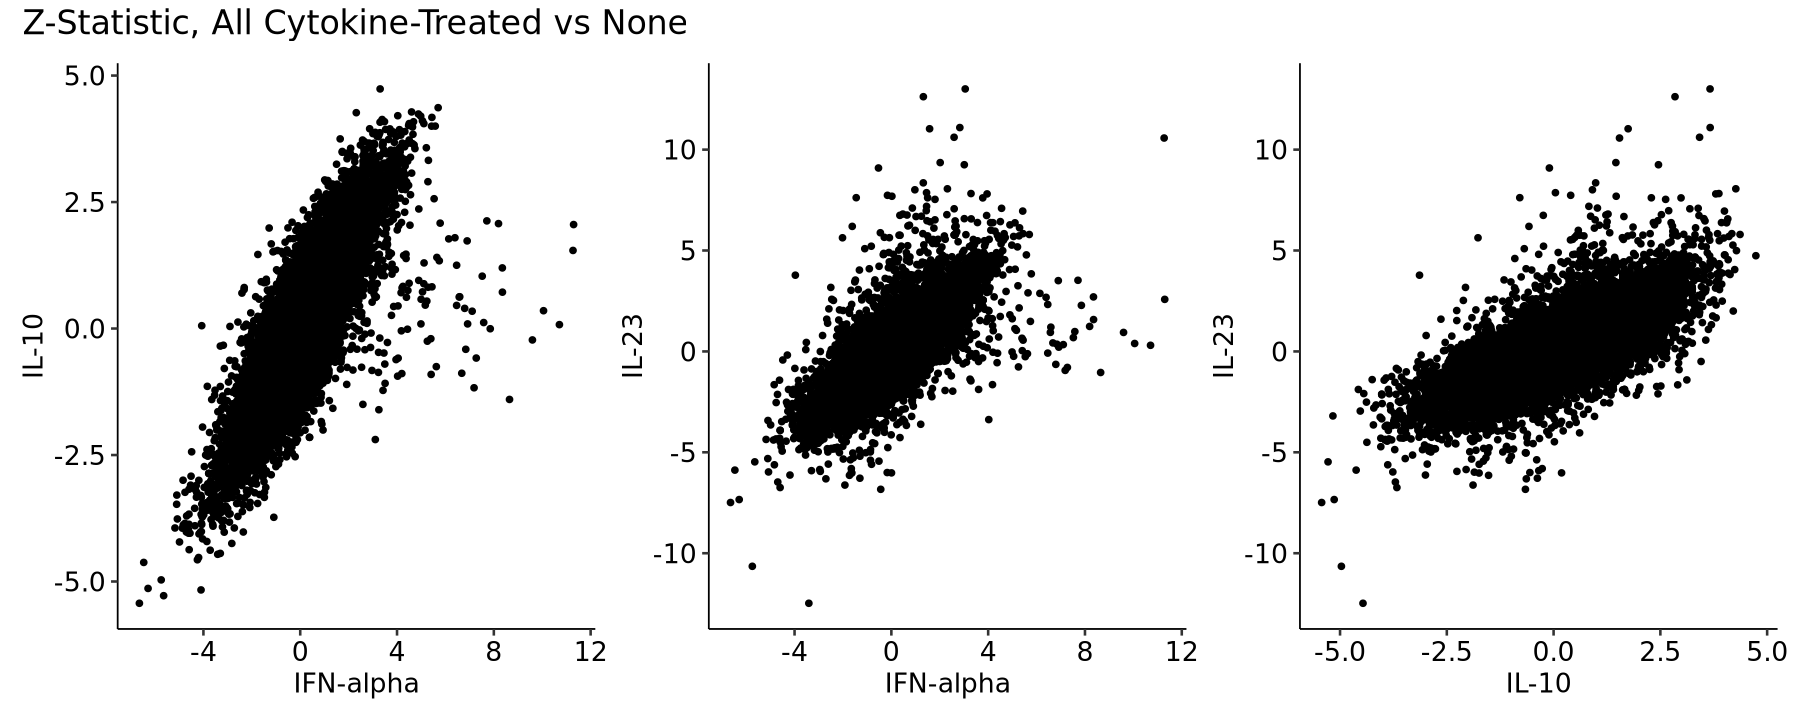

In [10]:
p1 <- sumstats %>%
    select(gene, stat, cytokine) %>%
    pivot_wider(names_from = cytokine, values_from = stat) %>%
    drop_na() %>%
    ggplot() +
        geom_point(aes(x = `IFN-alpha`,
                       y = `IL-10`)) +
        theme_pubr(base_size = 16)

p2 <- sumstats %>%
    select(gene, stat, cytokine) %>%
    pivot_wider(names_from = cytokine, values_from = stat) %>%
    drop_na() %>%
    ggplot() +
        geom_point(aes(x = `IFN-alpha`,
                       y = `IL-23`)) +
        theme_pubr(base_size = 16)

p3 <- sumstats %>%
    select(gene, stat, cytokine) %>%
    pivot_wider(names_from = cytokine, values_from = stat) %>%
    drop_na() %>%
    ggplot() +
        geom_point(aes(x = `IL-10`,
                       y = `IL-23`)) +
        theme_pubr(base_size = 16)

options(repr.plot.width = 15, repr.plot.height = 6)
p1 + p2 + p3 &
    plot_annotation(title = "Z-Statistic, All Cytokine-Treated vs None") &
    theme(plot.title = element_text(size = 20))

#### Global Profiling <a name="part3"></a>

In [11]:
vsd <- assay(vst(deresult, blind=FALSE))
vsd <- cbind(vsd, "row_var" = rowVars(vsd, na.rm = TRUE))

vsd_gene <- bind_cols("gene" = sumstats_ifna$gene,
                      vsd) %>%
    pivot_longer(names_to = "sample", values_to = "norm_value", `1`:`56`) %>%
    inner_join(samp_prop %>% mutate(sample_id = as.character(sample_id)),
               by = c("sample" = "sample_id"))

var_genes <- vsd_gene %>%
    select(gene, row_var) %>%
    distinct() %>%
    arrange(-row_var) %>%
    head(2000) %>%
    pull(gene)

vsd_gene_wide_sig <- vsd_gene %>%
    filter(gene %in% var_genes) %>%
    mutate(sample_name = str_c(cytokine, " ", dosage, " ", group, " ", time, " ", rep)) %>%
    select(gene, sample_name, norm_value) %>%
    pivot_wider(names_from = sample_name, values_from = norm_value)

vsd_gene_wide_all <- vsd_gene %>%
    mutate(sample_name = str_c(cytokine, " ", dosage, " ", group, " ", time, " ", rep)) %>%
    select(gene, sample_name, norm_value) %>%
    pivot_wider(names_from = sample_name, values_from = norm_value)

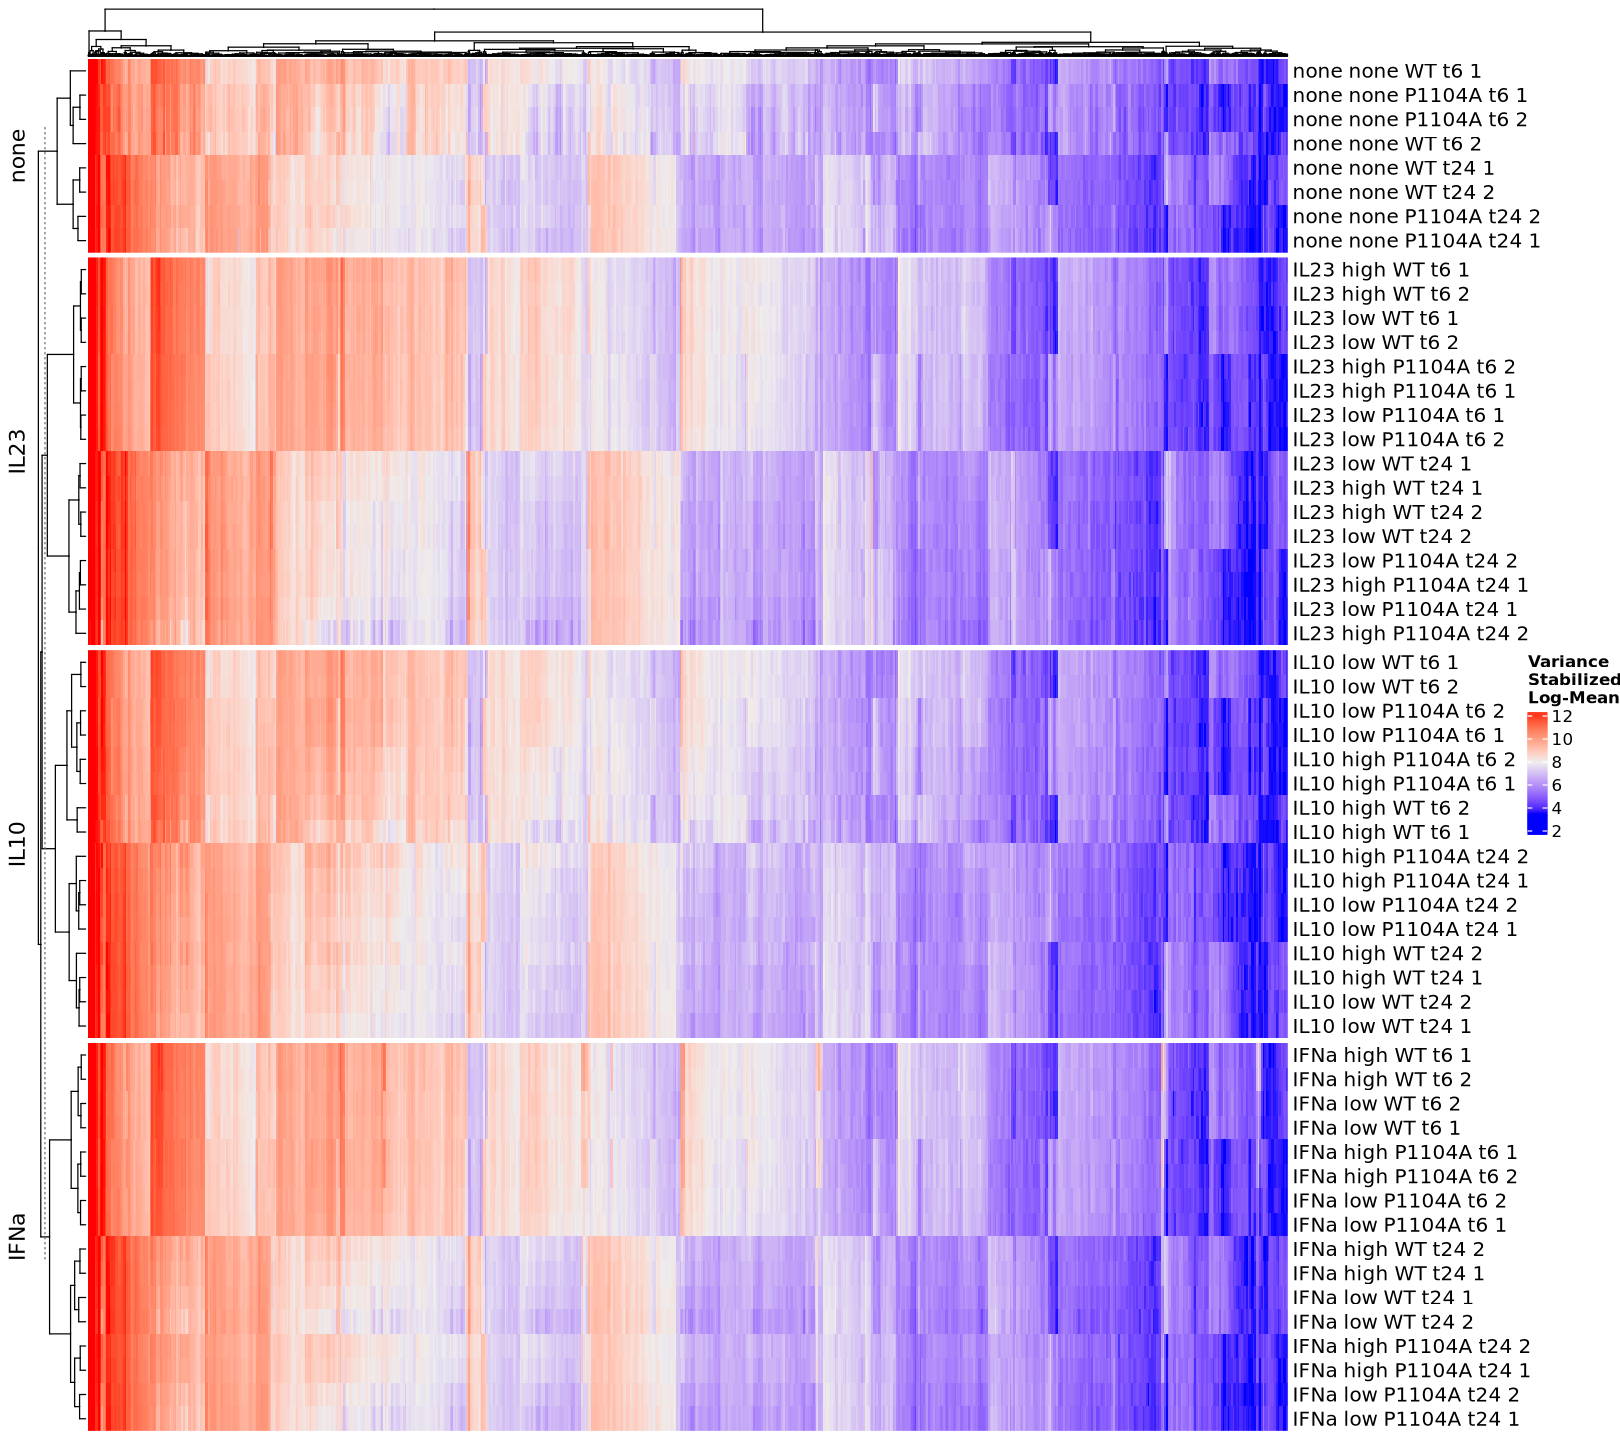

In [14]:
options(repr.plot.width = 13.5, repr.plot.height = 12)
Heatmap(t(as.matrix(vsd_gene_wide_sig[,-1])),
        cluster_columns = TRUE,
        cluster_rows = TRUE,
        row_split = gsub(" .*", "", names(vsd_gene_wide_sig[,-1])),
        use_raster = TRUE,
        raster_by_magick = TRUE,
        name = "Variance\nStabilized\nLog-Mean")

In [15]:
sig_genes_earlier <- read_tsv(c("~/bms-dms/sumstats/RNASEQ/diffexp//Tyk2-DE-P1104AvsWT.tsv.gz",
                                "~/bms-dms/sumstats/RNASEQ/diffexp//Tyk2-DE-CytokineP1104A.tsv.gz",
                                "~/bms-dms/sumstats/RNASEQ/diffexp//Tyk2-DE-CytokineWT.tsv.gz")) %>%
    filter(!grepl("ENSG", gene), !grepl("Luciferase", gene), doxy == 1000, padj < 0.05, abs(log2FoldChange) > 0.33) %>%
    pull(gene) %>%
    unique()

heat_genes_wide <- vsd_gene_wide_all[vsd_gene_wide_all$gene %in% sig_genes_earlier,]
heat_data <- t(as.matrix(heat_genes_wide[,-1]))
colnames(heat_data) <- unlist(heat_genes_wide[,1])

Rows: 105066 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): gene
dbl (7): baseMean, log2FoldChange, lfcSE, stat, pvalue, padj, doxy

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


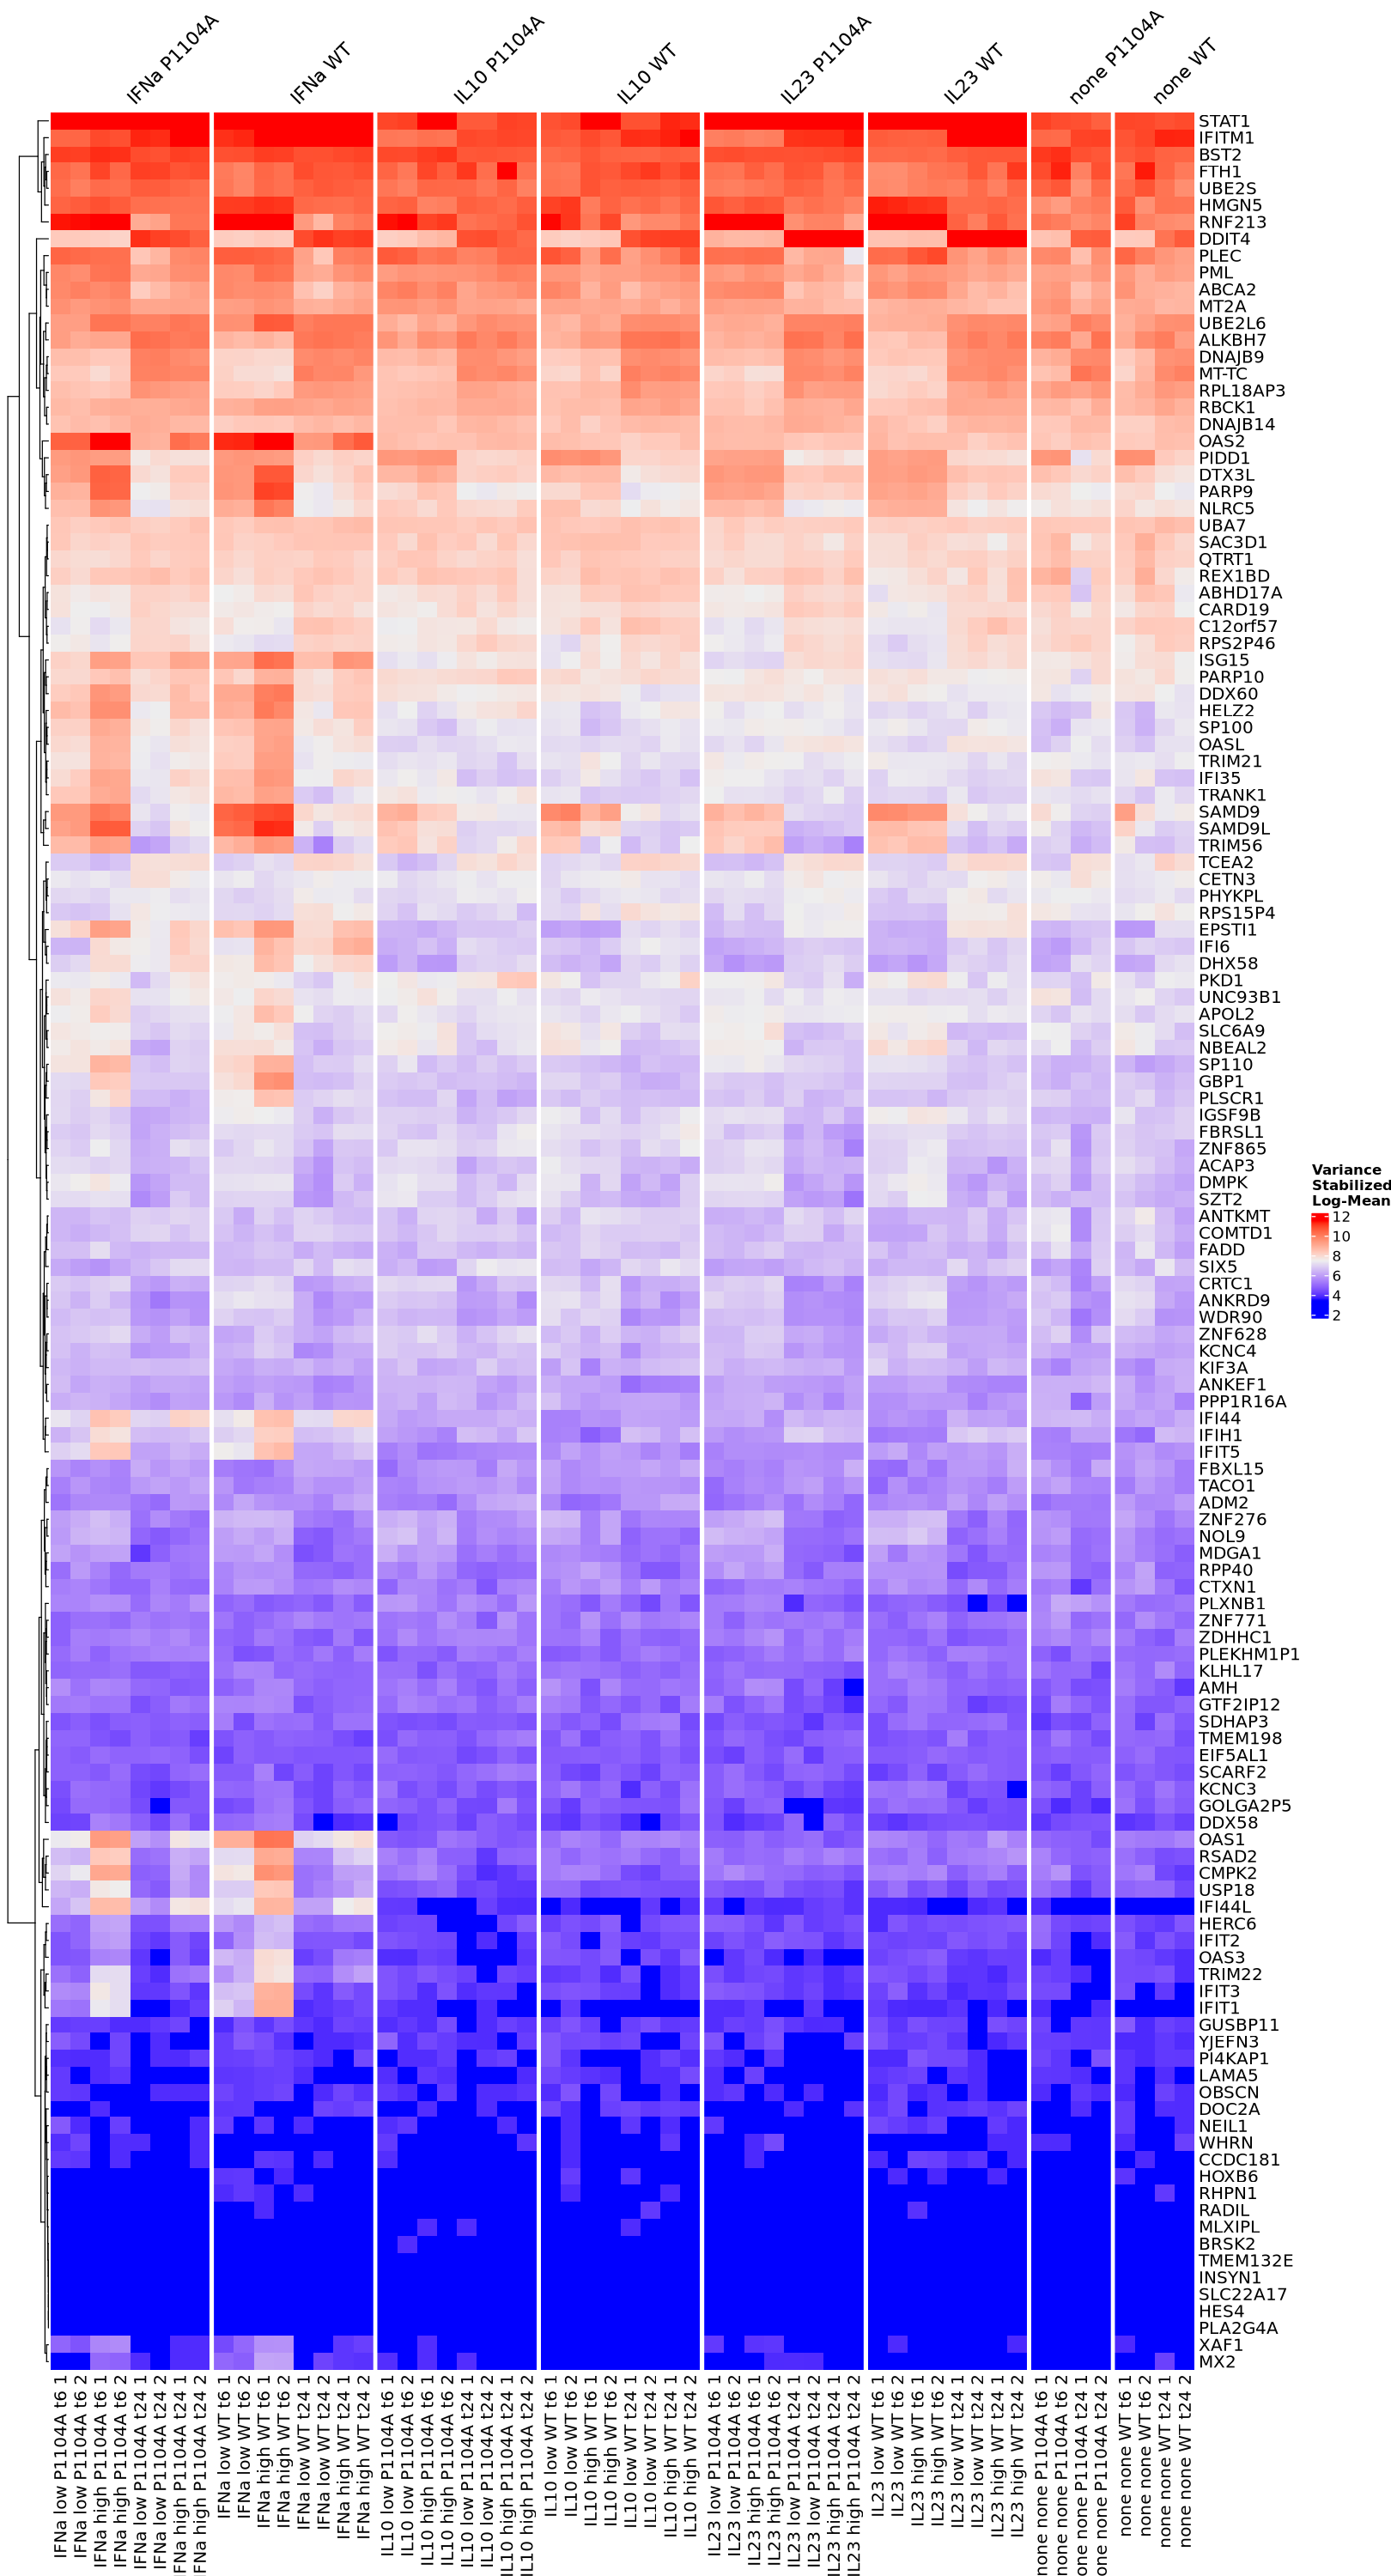

In [16]:
options(repr.plot.width = 13.5, repr.plot.height = 25)
#pdf("heat-immune-genes.pdf", width = 13.5, height = 25)
Heatmap(t(heat_data),
        cluster_columns = FALSE,
        cluster_rows = TRUE,
        column_split = gsub("low |high |t6|t24| 1| 2| none", "", colnames(heat_genes_wide[,-1])),
        use_raster = TRUE,
        column_title_rot = 45,
        name = "Variance\nStabilized\nLog-Mean")
#dev.off()

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


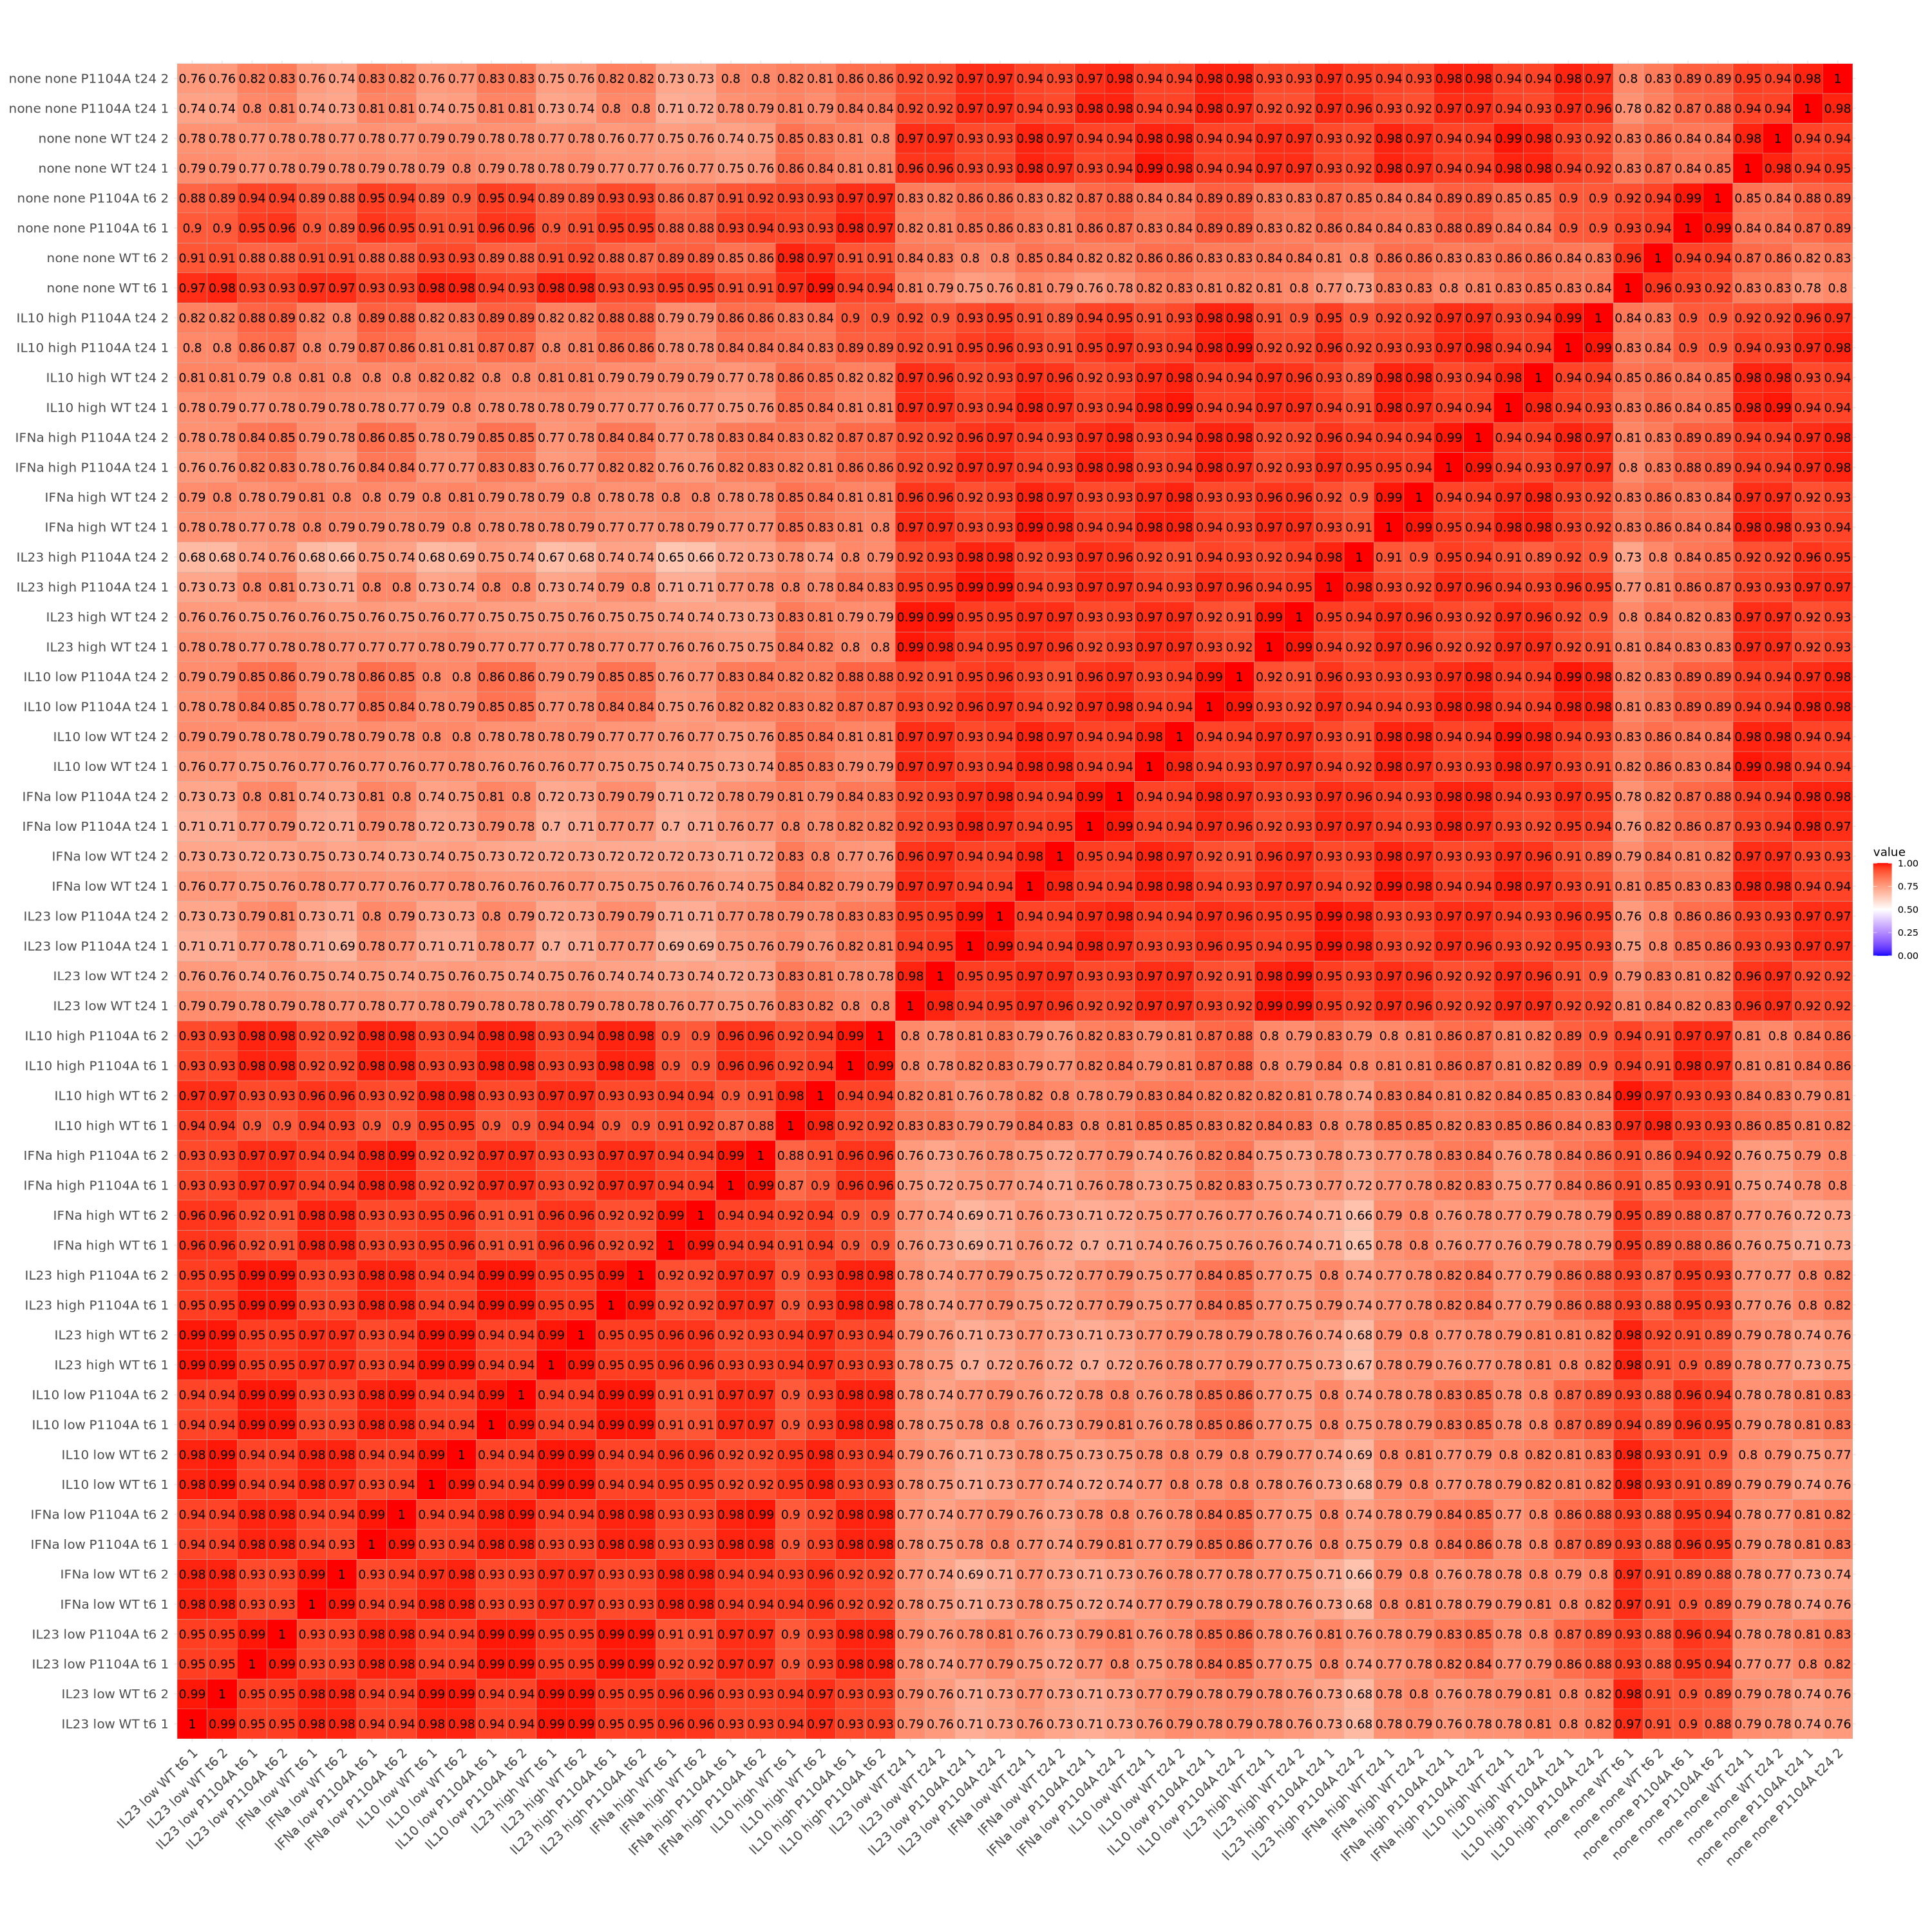

In [21]:
options(repr.plot.width = 25, repr.plot.height = 25)
#pdf("corrplot.pdf", width = 25, height = 25)
ggcorrplot(cor(log2(vsd_gene_wide_sig[,-1]),
               use = "pairwise.complete.obs"),
           lab = TRUE) +
    scale_fill_gradient2(limit = c(0,1), low = "blue", high =  "red", mid = "white", midpoint = 0.5)
#dev.off()

#### Gene Visualizations <a name="part4"></a>

In [22]:
plot_gene <- function(gene_id) {

    the_plot <- sumstats %>%
        filter(gene == gene_id) %>%
        ggplot() +
            geom_pointrange(aes(x = cytokine,
                                y = log2FoldChange,
                                ymin = log2FoldChange - 2*lfcSE,
                                ymax = log2FoldChange + 2*lfcSE)) +
            theme_pubr(base_size = 16) +
            ggtitle(gene_id) +
            coord_cartesian(ylim = c(-0.5, 3)) +
            geom_hline(yintercept = 0)

    return(the_plot)
    
}


stat1 <- plot_gene("STAT1")
stat2 <- plot_gene("STAT2")
stat3 <- plot_gene("STAT3")

jak1 <- plot_gene("JAK1")
jak2 <- plot_gene("JAK2")
jak3 <- plot_gene("JAK3")

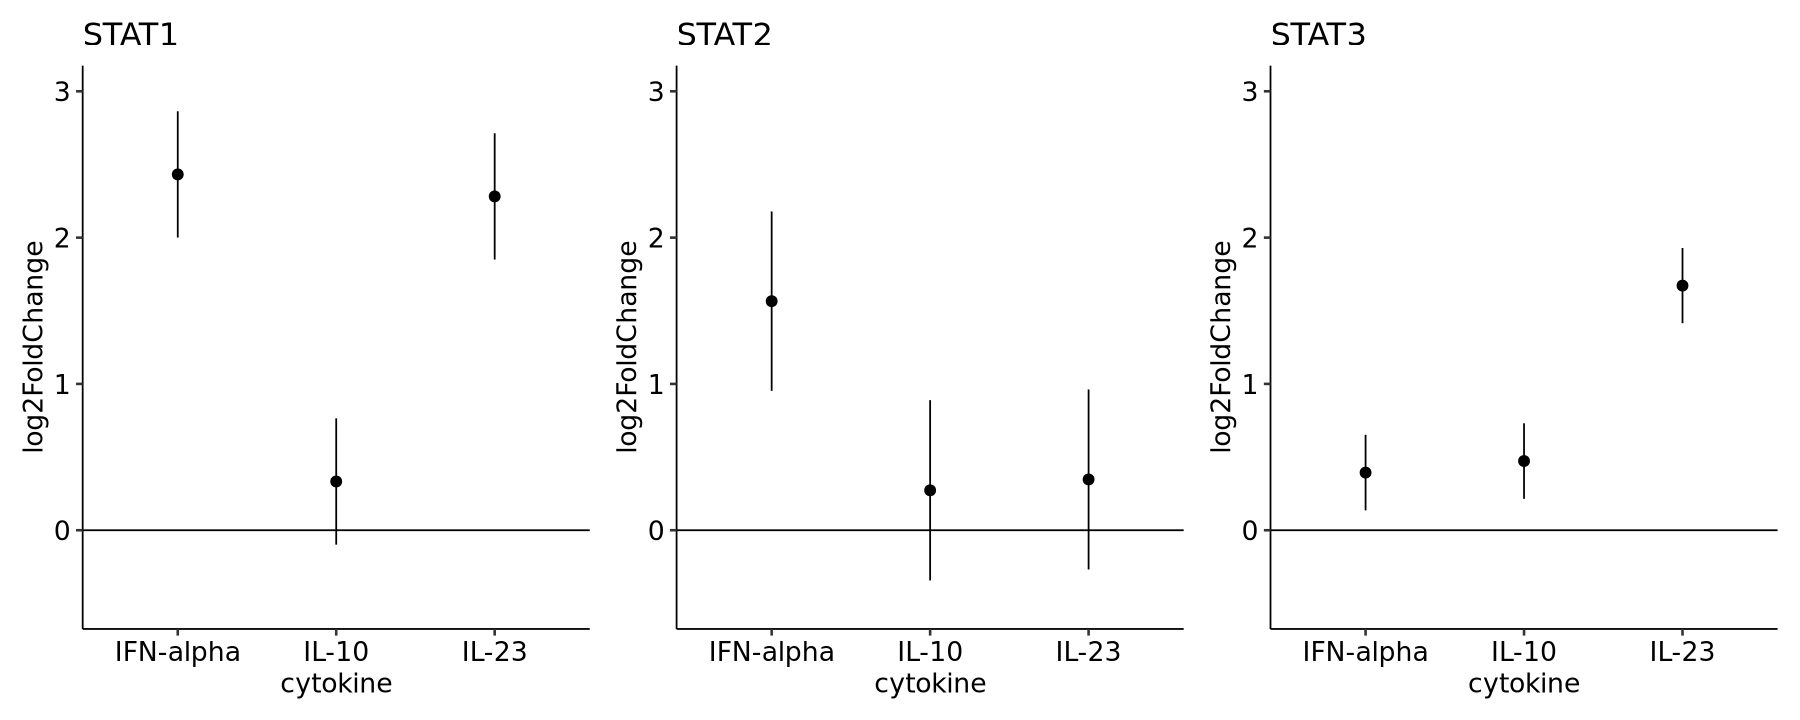

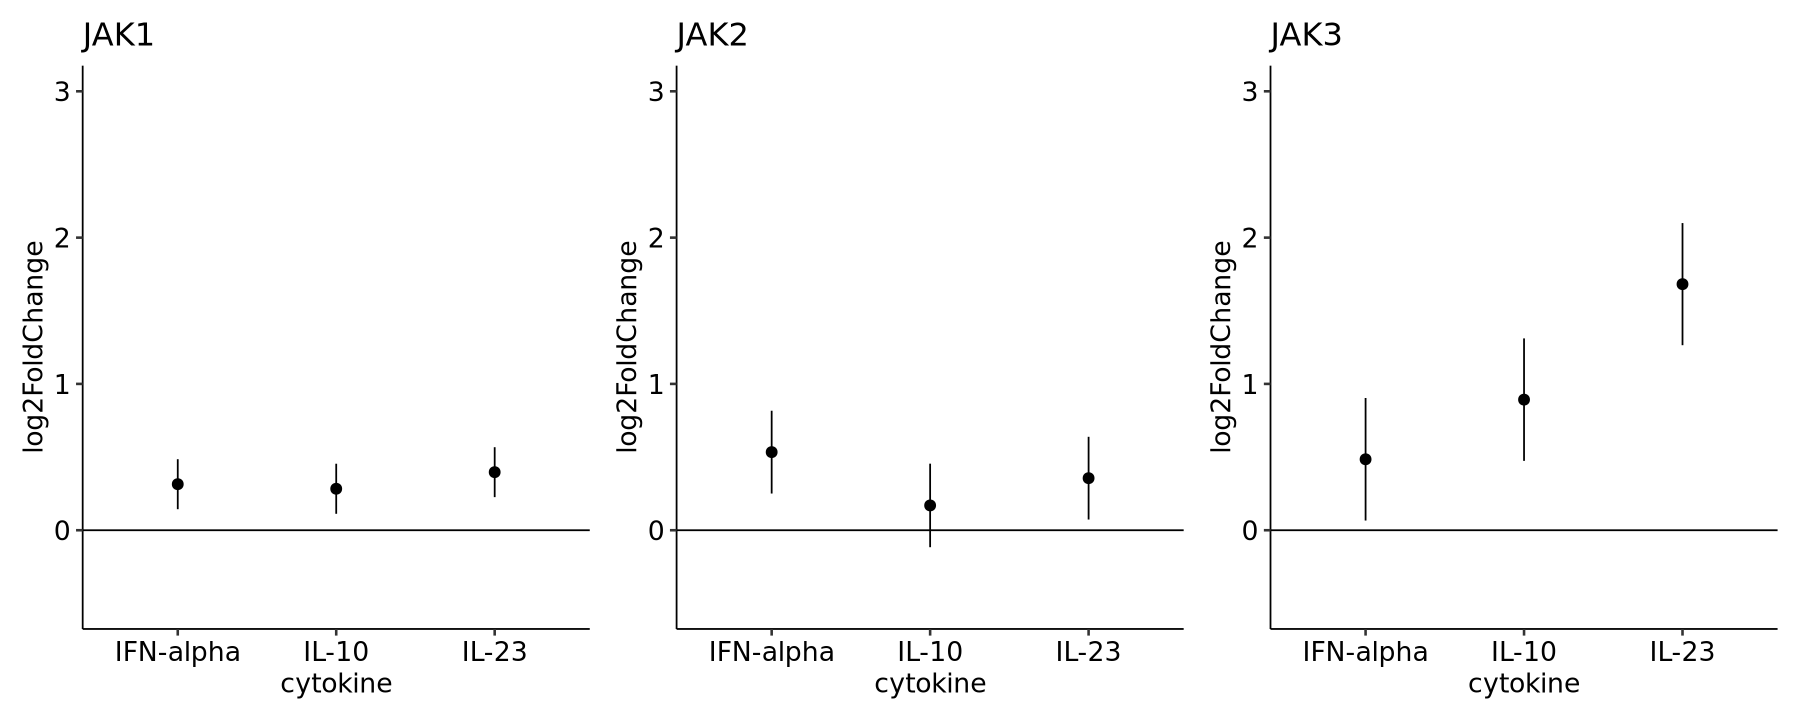

In [23]:
options(repr.plot.width = 15, repr.plot.height = 6)
stat1 + stat2 + stat3
jak1 + jak2 + jak3

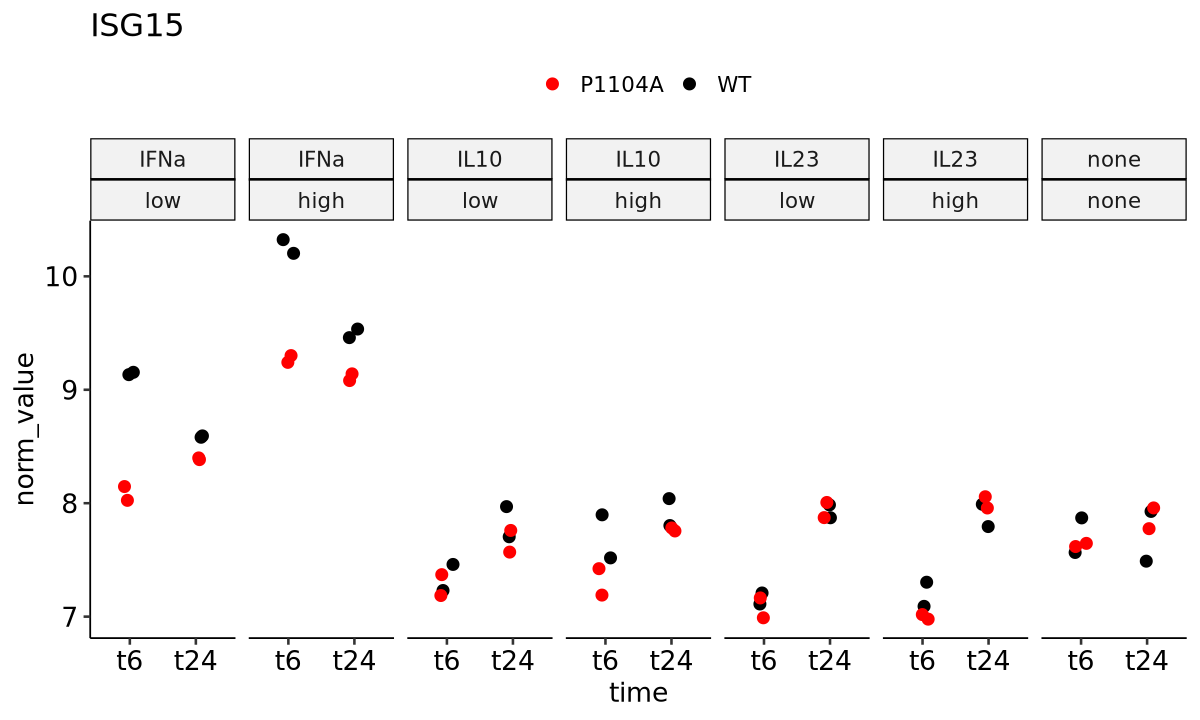

In [24]:
options(repr.plot.width = 10, repr.plot.height = 6)
vsd_gene %>%
    filter(gene == "ISG15") %>%
    mutate(time = relevel(as.factor(time), ref = "t6"),
           dosage = relevel(as.factor(dosage), ref = "low")) %>%
    ggplot() +
        geom_point(aes(x = time,
                       y = norm_value,
                       color = group), position = position_jitter(width = 0.1),
                   size = 3) +
        facet_wrap(~cytokine + dosage, nrow = 1) +
        theme_pubr(base_size = 16) +
        scale_color_manual(name = "",
                           values = c("WT" = "black",
                                      "P1104A" = "red")) +
        ggtitle("ISG15")